In [2]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation

In [3]:
from utils_model_sampling import sample_models_across_time

In [4]:
# 7/2/21: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2
# end cite

In [5]:
raw_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order()) # Should you run things locally?

Loading all all False 0 adult
Loading all all False 20 adult
Loading all all True 0 childes
Loading all all True 20 childes
Loading all all False 0 childes
Loading all all False 20 childes
Loading age young True 0 childes
Loading age young True 20 childes
Loading age young False 0 childes
Loading age young False 20 childes
Loading age old True 0 childes
Loading age old True 20 childes
Loading age old False 0 childes
Loading age old False 20 childes
Loading all all False 0 flat_unigram
Loading all all False 0 data_unigram


In [11]:
set(raw_scores_across_time['model'])

{'Adult BERT without tags, , +-20 utts context',
 'Adult BERT without tags, , same utt only',
 'CHILDES BERT with tags, , +-20 utts context',
 'CHILDES BERT with tags, , same utt only',
 'CHILDES BERT with tags, older children, +-20 utts context',
 'CHILDES BERT with tags, older children, same utt only',
 'CHILDES BERT with tags, younger children, +-20 utts context',
 'CHILDES BERT with tags, younger children, same utt only',
 'CHILDES BERT without tags, , +-20 utts context',
 'CHILDES BERT without tags, , same utt only',
 'CHILDES BERT without tags, older children, +-20 utts context',
 'CHILDES BERT without tags, older children, same utt only',
 'CHILDES BERT without tags, younger children, +-20 utts context',
 'CHILDES BERT without tags, younger children, same utt only',
 'CHILDES Unigram',
 'Flat Unigram'}

In [6]:
raw_scores_across_time['model'] # Need to select which?

# From the original analysis
original_set_of_models = {
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, , same utt only',
    'Adult BERT without tags, , +-20 utts context',
    'Adult BERT without tags, , same utt only',
    'CHILDES Unigram',
    'Flat Unigram',
}


is_filter = True
if is_filter:
# Don't filter
    scores_across_time = raw_scores_across_time[raw_scores_across_time.model.isin(original_set_of_models)]
else:
    scores_across_time = raw_scores_across_time

In [35]:
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_surprisal','posterior_entropy','prior_surprisal',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance']]
%R -i scores_across_time_short

/home/nwong/chompsky/childes/child_listening_continuation/child-listening-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
set(scores_across_time_short['model'])

{'Adult BERT without tags, , +-20 utts context',
 'Adult BERT without tags, , same utt only',
 'CHILDES BERT without tags, , +-20 utts context',
 'CHILDES BERT without tags, , same utt only',
 'CHILDES Unigram',
 'Flat Unigram'}

In [38]:
%%R
library('plyr')
# rename the models

# Do this manually for now.

model_levels = c("CHILDES BERT with tags, , +-20 utts context",
                 'CHILDES BERT without tags, , +-20 utts context',
                 "CHILDES BERT with tags, , same utt only",
                 "CHILDES BERT without tags, , same utt only",
                 "Adult BERT with tags, , +-20 utts context",
                 "Adult BERT without tags, , +-20 utts context",
                 "Adult BERT with tags, , same utt only",
                 "Adult BERT without tags, , same utt only",
                 "CHILDES BERT with tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, same utt only",
                 "CHILDES BERT with tags, older children, same utt only",
                 "CHILDES BERT with tags, younger children, +-20 utts context",
                 "CHILDES BERT without tags, younger children, +-20 utts context",
                 "CHILDES BERT with tags, younger children, same utt only",
                 "CHILDES BERT without tags, younger children, same utt only",
                 "CHILDES Unigram",
                 "Flat Unigram"
)

model_new_levels = c("CHILDES BERT with tags, , +-20 utts context" = "CDL+Context+Tags",
                    "CHILDES BERT without tags, , +-20 utts context" = "CDL+Context",
                    "CHILDES BERT with tags, , same utt only" = "CDL+OneUtt+Tags",
                    "CHILDES BERT without tags, , same utt only" = "CDL+OneUtt", 
                    "Adult BERT with tags, , +-20 utts context" = "BERT+Context+Tags",
                    "Adult BERT without tags, , +-20 utts context" = "BERT+Context",
                    "Adult BERT with tags, , same utt only" = "BERT+OneUtt+Tags",
                    "Adult BERT without tags, , same utt only" = "BERT+OneUtt",
                    "CHILDES BERT with tags, older children, +-20 utts context" = "CDL+Older+Context+Tags",
                    "CHILDES BERT without tags, older children, +-20 utts context" = "CDL+Older+Context",
                    "CHILDES BERT with tags, older children, same utt only" = "CDL+Older+OneUtt+Tags",
                    "CHILDES BERT without tags, older children, same utt only" = "CDL+Older+OneUtt",
                    "CHILDES BERT with tags, younger children, +-20 utts context" = "CDL+Younger+Context+Tags",
                    "CHILDES BERT without tags, younger children, +-20 utts context" = "CDL+Younger+Context",
                    "CHILDES BERT with tags, younger children, same utt only" = "CDL+Younger+OneUtt+Tags", 
                    "CHILDES BERT without tags, younger children, same utt only" = "CDL+Younger+OneUtt",
                    "CHILDES Unigram" = "CHILDES 1gram",
                    "Flat Unigram" = "UniformPrior"
)


scores_across_time_short$model = factor(scores_across_time_short$model, model_levels)
scores_across_time_short$model = revalue(scores_across_time_short$model, model_new_levels)

successes_across_time = subset(scores_across_time_short, set == 'success')

# 10 Average Prior Surprisal

In [42]:
%%R
names(successes_across_time)

aggregate(prior_surprisal ~ model, successes_across_time, function(x){mean(-1 * log(x, 2))})

             model prior_surprisal
1      CDL+Context        3.281851
2       CDL+OneUtt        5.047950
3     BERT+Context        5.328237
4 BERT+OneUtt+Tags        7.135952
5    CHILDES 1gram        8.779360
6     UniformPrior       12.948367


In [46]:
%%R

# 7/15/21 not a code reference, but debugging help:
# https://stackoverflow.com/questions/60083062/tidyrspread-error-each-row-of-output-must-be-identified-by-a-unique-combina
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325
# https://garrettgman.github.io/tidying

library('tidyr')
successes_across_time_wide =  spread(successes_across_time[,c('model','prior_surprisal',
'bert_token_id')], model, prior_surprisal)

head(successes_across_time_wide)

  bert_token_id CDL+Context   CDL+OneUtt BERT+Context BERT+OneUtt+Tags
1          3906         NaN          NaN           NA              NaN
2         12845 0.002408489 0.0001990781           NA     1.374489e-05
3         22281          NA           NA   0.06672563               NA
4         22853 0.113001950 0.1042684391           NA     7.057483e-02
5         22854 0.006315914 0.0081778280           NA     1.272983e-02
6         22855 0.381825954 0.5641137362           NA     2.748682e-01
  CHILDES 1gram UniformPrior
1           NaN          NaN
2  7.834548e-05 0.0001265182
3            NA           NA
4  3.958945e-03 0.0001265182
5  1.221330e-02 0.0001265182
6  3.958945e-03 0.0001265182


In [55]:
%%R
#Pairwise paired t-test between all of the models

model_names = unique(successes_across_time$model) 

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            
            rvs[model_idx, comparison_model_idx] = t.test(
                successes_across_time_wide[[model_name]], 
                successes_across_time_wide[[comparison_model_name]],
              paired=T)$p.value
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

   [1]          NaN 0.0001265182           NA 0.0001265182 0.0001265182
   [6] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
  [11] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
  [16] 0.0001265182           NA           NA 0.0001265182 0.0001265182
  [21] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
  [26] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
  [31] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
  [36] 0.0001265182          NaN 0.0001265182          NaN 0.0001265182
  [41] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
  [46] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
  [51] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
  [56] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
  [61] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
  [66] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.000

 [566] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [571] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [576] 0.0001265182 0.0001265182 0.0001265182           NA           NA
 [581] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [586] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [591] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [596] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [601] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [606] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [611] 0.0001265182 0.0001265182 0.0001265182          NaN 0.0001265182
 [616] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [621] 0.0001265182          NaN          NaN 0.0001265182 0.0001265182
 [626] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [631] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.000

[1131] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1136]           NA           NA 0.0001265182 0.0001265182 0.0001265182
[1141] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1146] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1151] 0.0001265182 0.0001265182 0.0001265182 0.0001265182          NaN
[1156] 0.0001265182 0.0001265182           NA 0.0001265182 0.0001265182
[1161] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1166] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1171] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1176] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1181] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1186] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1191] 0.0001265182          NaN 0.0001265182           NA           NA
[1196]           NA           NA           NA           NA 0.000

[1696] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1701] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1706] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1711] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1716] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1721] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1726] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1731] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1736] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1741] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1746] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1751] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1756] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1761] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 4.429028e-04 1.286813e-02 3.399313e-03 1.022228e-02
 [106] 1.460729e-03 1.648626e-03 5.271726e-03 3.133385e-03 5.271726e-03
 [111] 3.133385e-03 5.271726e-03 3.133385e-03 5.559814e-03 2.671759e-03
 [116] 1.920171e-03 1.560917e-05 1.250794e-02 1.215836e-02 4.375967e-04
 [121] 2.230292e-02          NaN 5.743338e-05 2.809401e-05 3.837842e-03
 [126] 2.780436e-02          NaN 2.532612e-02           NA 1.938302e-04
 [131] 9.401115e-04 3.273216e-03 1.020327e-03 2.277862e-03 4.088816e-04
 [136] 3.786059e-04 2.513448e-02 3.781036e-03 2.145835e-03 2.774787e-04
 [141] 2.532612e-02 4.054483e-04 3.407740e-03 3.281266e-02          NaN
 [146] 4.004543e-04 4.245157e-05 1.707333e-04 3.811028e-04 2.837211e-04
 [151] 1.111182e-04 4.869399e-05 2.189029e-02 2.780436e-02 1.221330e-02
 [156] 2.532612e-02 1.248487e-03 3.991406e-03 1.667665e-03 2.532612e-02
 [161] 2.532612e-02 2.532612e-02 3.933036e-05 2.532612e-02 3.933036e-05
 [166] 2.532612e-02 3.933036e-05 5.178402e-03 1.975729e-03 4.213446e-02
 [171] 4.78

 [671] 2.570254e-02 3.879695e-04 1.928939e-04 3.803509e-03 4.276369e-05
 [676] 2.532612e-02 1.812893e-02          NaN 3.803509e-03 2.780436e-02
 [681] 7.865760e-05 2.727968e-04 4.525785e-04 1.120830e-03 9.572781e-04
 [686] 1.120830e-03 2.532612e-02 6.192483e-03 1.812893e-02 1.305293e-03
 [691] 4.213446e-02 5.622238e-03 2.513448e-02 1.299051e-03 3.946773e-03
 [696] 1.676121e-04 4.925300e-04 1.001128e-02 2.780436e-02 7.896973e-05
 [701]          NaN 3.183946e-05 6.557661e-06           NA 2.780436e-02
 [706] 2.570254e-02 2.189029e-02 5.559814e-03 2.570254e-02           NA
 [711] 3.133385e-03 2.249147e-03 3.650882e-03 1.250794e-02 1.481170e-02
 [716] 1.286813e-02 2.189029e-02 4.213446e-02 3.650882e-03 1.250794e-02
 [721] 1.481170e-02 1.286813e-02 1.607426e-03 4.213446e-02 5.178402e-03
 [726] 1.481170e-02 1.068827e-02 2.780436e-02 1.460729e-03 5.090724e-04
 [731] 4.694331e-04 3.407740e-03 3.817555e-03 1.812893e-02 1.460729e-03
 [736] 3.967089e-04 7.384813e-04 1.283757e-03 2.599999e-04 1.648

[1236] 2.057505e-03 6.492428e-05          NaN 5.933420e-06 1.812893e-02
[1241] 1.215836e-02 2.230292e-02 2.310007e-05 7.329852e-03 5.271726e-03
[1246]           NA           NA 3.273216e-03 8.710675e-03 7.968763e-03
[1251] 2.513448e-02 7.968763e-03 2.513448e-02 3.399313e-03 1.394247e-03
[1256] 9.894266e-04 9.894266e-04 4.538270e-04 1.866515e-04 4.213446e-02
[1261] 1.509420e-03           NA           NA           NA 6.052057e-04
[1266]           NA           NA 1.215836e-02 1.215836e-02 4.276088e-04
[1271] 1.481170e-02 1.082439e-03 6.738723e-04 4.975239e-04 1.286813e-02
[1276] 4.027612e-03 1.743511e-03 1.273145e-03 1.286813e-02 4.027612e-03
[1281] 1.743511e-03 1.273145e-03 9.529084e-04 6.738723e-04 4.975239e-04
[1286] 4.756755e-04 2.057505e-03 3.399313e-03           NA           NA
[1291]           NA           NA           NA           NA           NA
[1296]           NA           NA           NA           NA           NA
[1301]           NA           NA 6.336368e-05 4.023554e-03      

[1801] 1.186372e-05 2.780436e-02 1.395212e-04 5.271726e-03 4.589118e-03
[1806] 9.745356e-03 1.216026e-03 2.513448e-02 1.204818e-04 2.277862e-03
[1811] 2.277862e-03 3.741397e-03 1.216026e-03 2.513448e-02 1.204818e-04
[1816] 6.080148e-04 4.589118e-03 9.745356e-03 1.216026e-03 2.513448e-02
[1821] 1.204818e-04 2.570254e-02 2.513448e-02 1.232909e-04 8.611449e-04
[1826] 1.283757e-03 1.213842e-03 2.513448e-02           NA 1.052163e-03
[1831] 3.281266e-02 1.082439e-03 1.020327e-03 4.144998e-04 3.238258e-03
[1836] 3.238258e-03 1.607454e-04 1.238499e-03 1.607454e-04 1.238499e-03
[1841] 4.213446e-02 5.187141e-03 2.913028e-03 1.122543e-02 5.559814e-03
[1846] 9.745356e-03 1.394247e-03 5.282026e-03 5.416862e-03 3.281266e-02
[1851] 4.026673e-05 6.426886e-03           NA           NA           NA
[1856]           NA 3.399313e-03 3.266037e-03 1.661111e-03           NA
[1861] 1.221330e-02 8.190994e-03 1.220424e-04 3.281266e-02 8.333942e-05
[1866] 1.481170e-02 1.068827e-02 4.213446e-02 6.425325e-03 3.991

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 [336] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [341] 0.0001265182 0.0001265182 0.0001265182           NA           NA
 [346] 0.0001265182 0.0001265182 0.0001265182          NaN 0.0001265182
 [351] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [356] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [361] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [366] 0.0001265182 0.0001265182           NA 0.0001265182 0.0001265182
 [371] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [376] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [381] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [386] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [391] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [396] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [401] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.000

 [901] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [906] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [911] 0.0001265182 0.0001265182 0.0001265182 0.0001265182           NA
 [916]           NA 0.0001265182           NA 0.0001265182 0.0001265182
 [921] 0.0001265182 0.0001265182           NA           NA           NA
 [926]           NA           NA           NA           NA 0.0001265182
 [931] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [936] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [941] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [946] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [951] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [956]          NaN 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [961] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
 [966] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.000

[1466] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1471] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1476] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1481] 0.0001265182 0.0001265182          NaN 0.0001265182 0.0001265182
[1486] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1491] 0.0001265182 0.0001265182 0.0001265182 0.0001265182           NA
[1496]           NA           NA           NA           NA 0.0001265182
[1501] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1506] 0.0001265182 0.0001265182 0.0001265182 0.0001265182           NA
[1511] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1516] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1521] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1526] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[1531] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.000

[2031]          NaN 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[2036] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[2041] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[2046] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[2051] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[2056] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[2061] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[2066] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[2071] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[2076] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[2081] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[2086]           NA 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[2091] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.0001265182
[2096] 0.0001265182 0.0001265182 0.0001265182 0.0001265182 0.000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



           NA
 [836]           NA           NA           NA           NA           NA
 [841]           NA           NA           NA           NA           NA
 [846]           NA           NA           NA           NA           NA
 [851]           NA           NA           NA           NA           NA
 [856] 6.818120e-01 8.374369e-01 2.292144e-04 3.633274e-03 1.209357e-05
 [861]           NA           NA           NA           NA           NA
 [866]           NA           NA           NA           NA           NA
 [871]           NA           NA           NA           NA           NA
 [876]           NA           NA           NA           NA           NA
 [881]           NA           NA           NA           NA           NA
 [886]           NA           NA           NA           NA           NA
 [891]           NA           NA           NA           NA           NA
 [896]           NA           NA           NA           NA           NA
 [901]           NA           NA           NA     

[1401]           NA           NA           NA 3.737445e-02 2.686222e-02
[1406]           NA           NA           NA           NA           NA
[1411]           NA           NA           NA           NA           NA
[1416] 9.998682e-01 9.948102e-01 9.913430e-01 9.970545e-01 9.999653e-01
[1421] 9.998424e-01 9.948900e-01 9.758196e-01 5.957949e-01           NA
[1426]           NA           NA           NA           NA           NA
[1431]           NA           NA           NA           NA           NA
[1436]           NA           NA           NA           NA           NA
[1441]           NA           NA           NA           NA           NA
[1446]           NA           NA           NA           NA           NA
[1451]           NA           NA           NA           NA           NA
[1456]           NA           NA           NA           NA           NA
[1461]           NA           NA           NA           NA           NA
[1466]           NA           NA           NA           NA      

[1966]           NA           NA           NA           NA           NA
[1971]           NA           NA           NA           NA           NA
[1976]           NA           NA           NA           NA           NA
[1981]           NA           NA           NA           NA           NA
[1986]           NA           NA           NA           NA           NA
[1991]           NA           NA           NA           NA           NA
[1996]           NA           NA           NA           NA           NA
[2001]           NA           NA           NA           NA           NA
[2006]           NA           NA           NA           NA           NA
[2011]           NA           NA           NA           NA           NA
[2016]           NA           NA           NA           NA           NA
[2021]           NA           NA           NA           NA           NA
[2026]           NA           NA           NA           NA           NA
[2031]           NA           NA           NA           NA      

R[write to console]: Error in t.test.default(successes_across_time_wide[[model_name]], successes_across_time_wide[[comparison_model_name]],  : 
  not enough 'x' observations




Error in t.test.default(successes_across_time_wide[[model_name]], successes_across_time_wide[[comparison_model_name]],  : 
  not enough 'x' observations


### Posterior Surprisal Across Ages

## Note to self: Check correctness of young/old divide len stdev here -- possibly ask about this; Is probably adaptive?

In [57]:
%R sem <- function(x) sd(x)/sqrt(length(x))
%R mean_surprisal_by_age = aggregate(posterior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x))})
%R names(mean_surprisal_by_age) = c('age','model','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
%R print(mean_surprisal_by_age)

   age            model posterior_surprisal_mean posterior_surprisal_sem
1  0.5     BERT+Context                1.1088649               0.6427529
2  0.5 BERT+OneUtt+Tags                6.2284411               6.4582100
3  0.5      CDL+Context                1.4762644               2.1296580
4  0.5       CDL+OneUtt                3.4920723               5.0370074
5  0.5    CHILDES 1gram                4.2455319               6.1038578
6  0.5     UniformPrior                5.1073118               6.9476077
7  1.5     BERT+Context                2.3141917               1.0038795
8  1.5 BERT+OneUtt+Tags                3.1121703               0.2618958
9  1.5      CDL+Context                0.9684134               0.1468465
10 1.5       CDL+OneUtt                2.1610092               0.2243804
11 1.5    CHILDES 1gram                3.5008754               0.2871633
12 1.5     UniformPrior                4.3642003               0.2620541
13 1.0     BERT+Context                4.2761179   

,age,model,posterior_surprisal_mean,posterior_surprisal_sem
1,0.5,BERT+Context,1.108865,0.642753
2,0.5,BERT+OneUtt+Tags,6.228441,6.458210
3,0.5,CDL+Context,1.476264,2.129658
4,0.5,CDL+OneUtt,3.492072,5.037007
5,0.5,CHILDES 1gram,4.245532,6.103858
6,0.5,UniformPrior,5.107312,6.947608
7,1.5,BERT+Context,2.314192,1.003879
8,1.5,BERT+OneUtt+Tags,3.112170,0.261896
9,1.5,CDL+Context,0.968413,0.146846
10,1.5,CDL+OneUtt,2.161009,0.224380


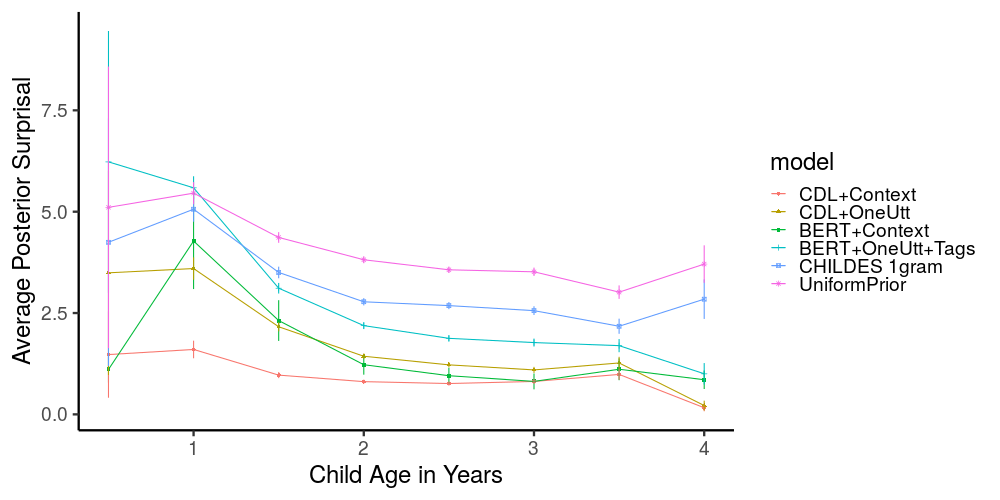

In [58]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years')

### Prior Surprisal Across Ages

In [59]:
## scores_across_time = pd.concat(score_store)
%R mean_surprisal_by_age = aggregate(prior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x))})
%R names(mean_surprisal_by_age_sem) = c('age','model','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,prior_surprisal_mean,prior_surprisal_sem
1,0.5,BERT+Context,4.547977,0.770874
2,0.5,BERT+OneUtt+Tags,14.480383,0.713066
3,0.5,CDL+Context,0.273294,0.106330
4,0.5,CDL+OneUtt,3.174219,1.857451
5,0.5,CHILDES 1gram,8.155822,0.068798
6,0.5,UniformPrior,12.948367,0.000000
7,1.5,BERT+Context,7.895279,1.089959
8,1.5,BERT+OneUtt+Tags,8.642180,0.205887
9,1.5,CDL+Context,3.421072,0.162766
10,1.5,CDL+OneUtt,6.126683,0.176624


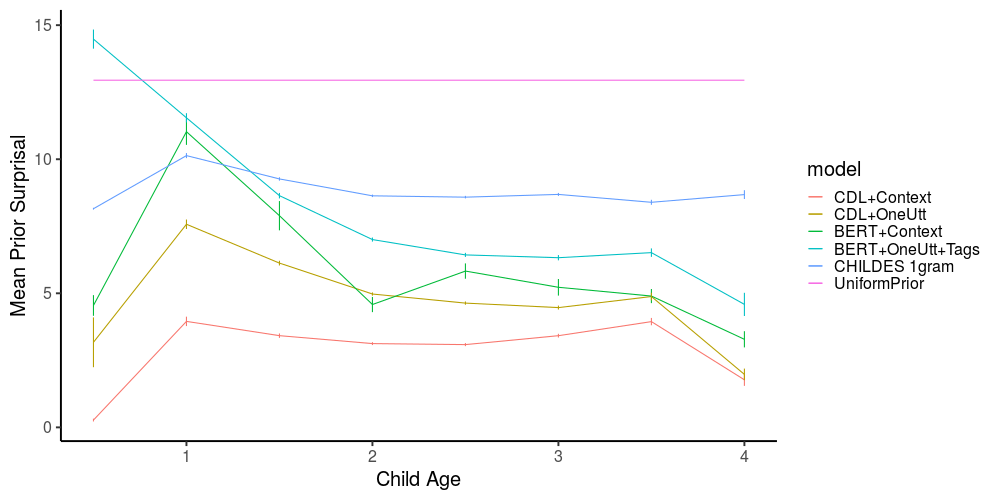

In [60]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
ymax=prior_surprisal_mean + .5*prior_surprisal_sem , color=model), width=0) + theme_classic(
base_size=20) + ylab('Mean Prior Surprisal') + xlab('Child Age')

In [62]:
scores_across_time_short.set.value_counts()

success    11402
failure     5081
Name: set, dtype: int64

### Posterior Entropy Stratified by Successes vs. Failures

In [64]:
%R posterior_entropy_by_age = aggregate(posterior_entropy ~ age + model + set, scores_across_time_short ,\
                function(x){mean(x)})
%R names(posterior_entropy_by_age) = c('age','model', 'set', 'posterior_entropy_mean')
%R posterior_entropy_by_age_sem = aggregate(posterior_entropy ~ age + model + set, \
        scores_across_time_short, sem)
%R names(posterior_entropy_by_age_sem) = c('age','model','set','posterior_entropy_sem')
%R posterior_entropy_by_age = merge(posterior_entropy_by_age, posterior_entropy_by_age_sem) 
%R posterior_entropy_by_age

,age,model,set,posterior_entropy_mean,posterior_entropy_sem
1,0.5,BERT+Context,failure,3.077988,0.370473
2,0.5,BERT+Context,success,1.357110,0.383220
3,0.5,BERT+OneUtt+Tags,failure,4.108678,0.459334
4,0.5,BERT+OneUtt+Tags,success,2.715195,0.332250
5,0.5,CDL+Context,failure,3.572890,0.344146
...,...,...,...,...,...
87,4.0,BERT+OneUtt+Tags,success,0.907204,0.236242
88,4.0,CDL+Context,success,0.276949,0.124973
89,4.0,CDL+OneUtt,success,0.301997,0.125455
90,4.0,CHILDES 1gram,success,1.994985,0.251594


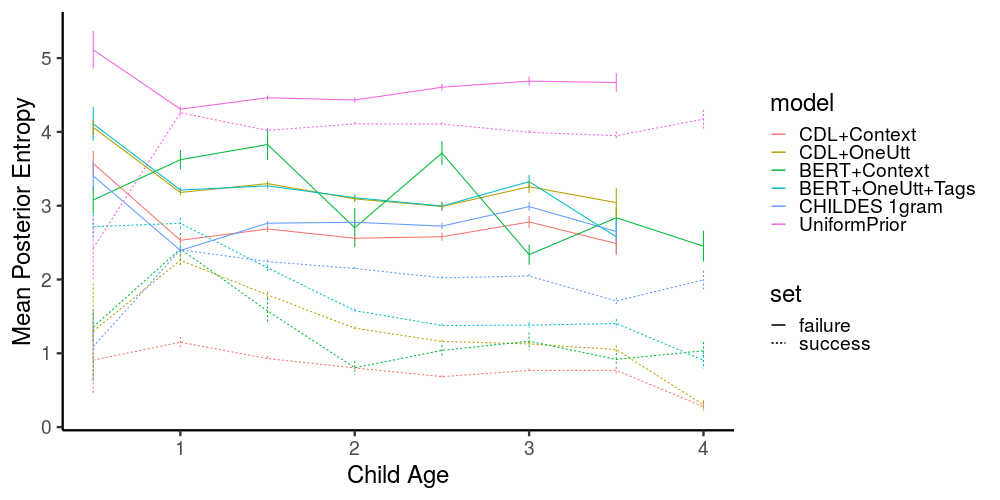

In [65]:
%%R -w 1000 -h 500
ggplot(posterior_entropy_by_age) + geom_line(aes(x=age, y=posterior_entropy_mean, color=model, linetype=set)
) + geom_errorbar(aes(x=age, ymin=posterior_entropy_mean - .5*posterior_entropy_sem, 
ymax=posterior_entropy_mean + .5*posterior_entropy_sem, color=model, linetype=set ), width=0) + theme_classic(
base_size=24) + ylab('Mean Posterior Entropy') + xlab('Child Age')

# 11 Information Gain 

In [66]:
%%R
# adjust the base from log to 2 in successes_across_time
successes_across_time$kl_flat_to_prior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_prior), base=2)
successes_across_time$kl_flat_to_posterior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_posterior), base=2)

In [67]:
%%R
mean_kl_flat_to_prior_by_age = aggregate(kl_flat_to_prior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_prior_by_age) = c('age','model','kl_flat_to_prior')
mean_kl_flat_to_prior_by_age_sem = aggregate(kl_flat_to_prior ~ age + model,
        successes_across_time, sem)
names(mean_kl_flat_to_prior_by_age_sem) = c('age','model','kl_flat_to_prior_sem')
mean_kl_flat_to_prior_by_age = merge(mean_kl_flat_to_prior_by_age, mean_kl_flat_to_prior_by_age_sem) 


mean_kl_flat_to_posterior_by_age = aggregate(kl_flat_to_posterior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_posterior_by_age) = c('age','model','kl_flat_to_posterior')
mean_kl_flat_to_posterior_by_age_sem = aggregate(kl_flat_to_posterior ~ age + model, 
        successes_across_time, sem)
names(mean_kl_flat_to_posterior_by_age_sem) = c('age','model','kl_flat_to_posterior_sem')
mean_kl_flat_to_posterior_by_age = merge(mean_kl_flat_to_posterior_by_age, 
    mean_kl_flat_to_posterior_by_age_sem) 

names(mean_kl_flat_to_posterior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_posterior_by_age$comparison = 'posterior'

names(mean_kl_flat_to_prior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_prior_by_age$comparison =  'fitted prior'

kls = rbind.fill(mean_kl_flat_to_posterior_by_age, mean_kl_flat_to_prior_by_age)
kls$age_in_months = kls$age * 12
head(kls)

  age            model     gain   gain_sem comparison age_in_months
1 0.5     BERT+Context 15.90369 1.07993502  posterior             6
2 0.5 BERT+OneUtt+Tags 10.96785 0.51159655  posterior             6
3 0.5      CDL+Context 23.48716 4.43136584  posterior             6
4 0.5       CDL+OneUtt 20.78312 4.26538879  posterior             6
5 0.5    CHILDES 1gram 20.37815 0.67615613  posterior             6
6 0.5     UniformPrior 11.12379 0.06833978  posterior             6


In [68]:
%%R
subset(kls, comparison =='posterior' & model == 'UniformPrior')

   age        model      gain   gain_sem comparison age_in_months
6  0.5 UniformPrior 11.123794 0.06833978  posterior             6
12 1.5 UniformPrior  9.802213 0.09244900  posterior            18
18 1.0 UniformPrior  9.185868 0.18460783  posterior            12
24 2.5 UniformPrior  9.788494 0.06703126  posterior            30
30 2.0 UniformPrior  9.806576 0.07046811  posterior            24
36 3.5 UniformPrior 10.120902 0.15152114  posterior            42
42 3.0 UniformPrior  9.942994 0.09269263  posterior            36
48 4.0 UniformPrior  9.970488 0.40231954  posterior            48


In [69]:
%%R
# how to get the unigrams on every line
unigram_posterior = subset(kls, comparison =='posterior' & model == 'UniformPrior')
unigram_posterior['comparison'] = 'perceptual data'

excluding_unigram = subset(kls, model != 'UniformPrior')
by_model = split(excluding_unigram, as.character(excluding_unigram$model))
kls_with_uniform_prior = do.call('rbind', lapply(by_model, function(one_model){
        # merge by age in months
        unigram_posterior['model'] = one_model$model[1]
        return(rbind(one_model, unigram_posterior))    
})) 

In [70]:
%%R
kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'fitted prior'] = "context (fitted prior)"

kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'posterior'] = "perceptual data & context\n(posterior)"

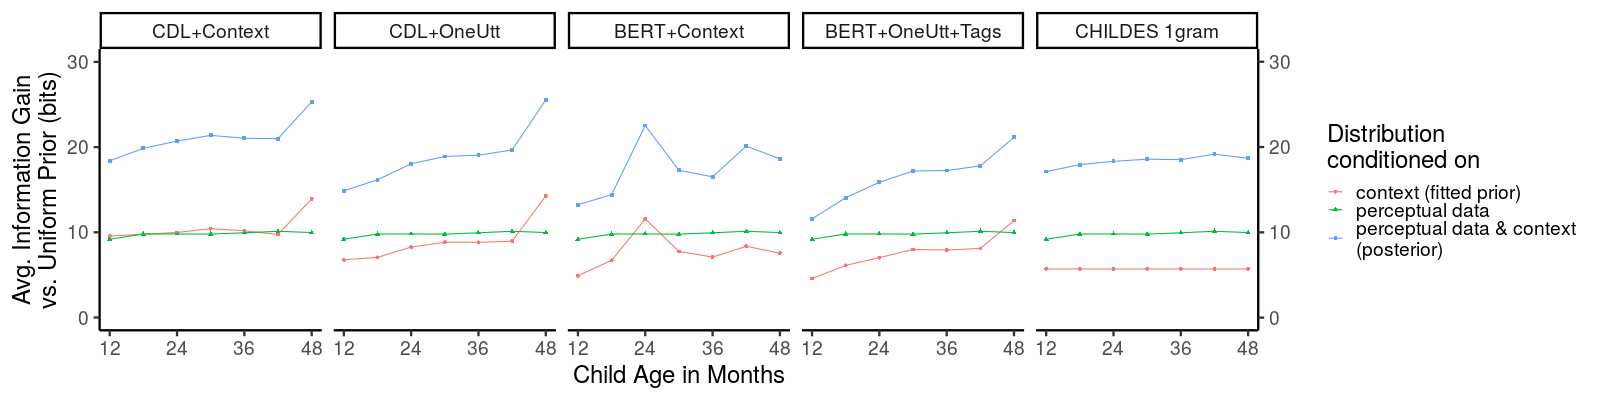

In [71]:
%%R -w 1600 -h 400
child_age_ticks = c(12,24,36,48) 
p1 = ggplot(subset(kls_with_uniform_prior, age_in_months > 6)) + geom_point(aes(x=age_in_months, 
y= gain, color=comparison,  shape=comparison)
) + facet_wrap(~model, ncol=5) + geom_line(aes(x=age_in_months, y= gain, color=comparison, 
shape=comparison)) + theme_classic(base_size=24) + coord_cartesian(ylim = c(0,30)
) + xlab('Child Age in Months') + ylab('Avg. Information Gain\nvs. Uniform Prior (bits)'
) + scale_y_continuous(sec.axis = sec_axis( trans=~.)
) + scale_color_discrete(name = "Distribution\nconditioned on") + scale_shape_discrete(
name = "Distribution\nconditioned on") + scale_x_continuous( breaks = child_age_ticks, 
labels = child_age_ticks)
ggsave('figures/information_gain_2.pdf', width=16, height=4)
print(p1)

# 12 Posterior Probability as a function of edit distance

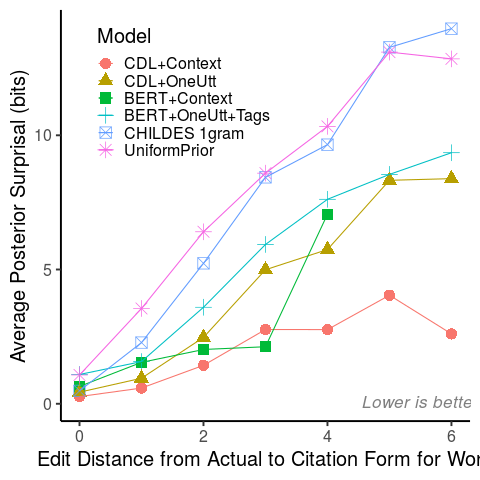

In [72]:
%%R
surprisal_by_edit_distance = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){mean(-1 * log(x))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){sem(-1 * log(x))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal 
    + 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal 
    - 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
test = subset(surprisal_by_edit_distance, edit_distance ==1 )
test$prob = exp(-1*test$mean_posterior_surprisal)

p1= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_distance.pdf', height=6, width=8)    
print(p1)

In [73]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior")[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance = merge(surprisal_by_edit_distance, unigram_prior)
surprisal_by_edit_distance$multiplier = 2^( surprisal_by_edit_distance$unigram_prior_prob -
    surprisal_by_edit_distance$mean_posterior_surprisal)

head(surprisal_by_edit_distance, n=10)


   edit_distance            model mean_posterior_surprisal
1              0     BERT+Context                0.6455750
2              0 BERT+OneUtt+Tags                1.0898110
3              0      CDL+Context                0.2679434
4              0       CDL+OneUtt                0.4311810
5              0    CHILDES 1gram                0.4816374
6              0     UniformPrior                1.0725353
7              1     BERT+Context                1.5424065
8              1 BERT+OneUtt+Tags                1.5713785
9              1      CDL+Context                0.5850883
10             1       CDL+OneUtt                0.9509689
   mean_posterior_surprisal_sem      high       low unigram_prior_prob
1                    0.12327461 0.6455750 0.6455750           1.072535
2                    0.05874765 1.0898110 1.0898110           1.072535
3                    0.02615884 0.2679434 0.2679434           1.072535
4                    0.03590252 0.4311810 0.4311810           1.072

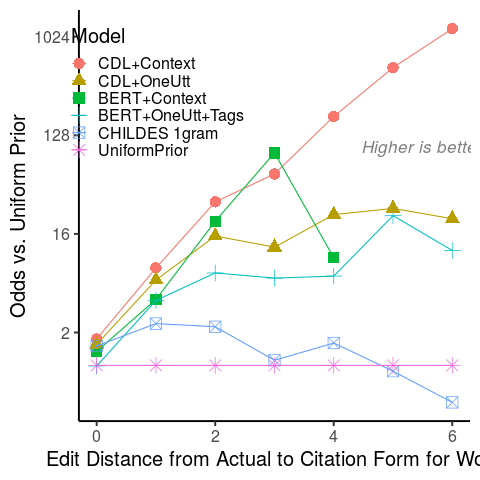

In [74]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale.pdf', height=6, width=8)    
print(p2)

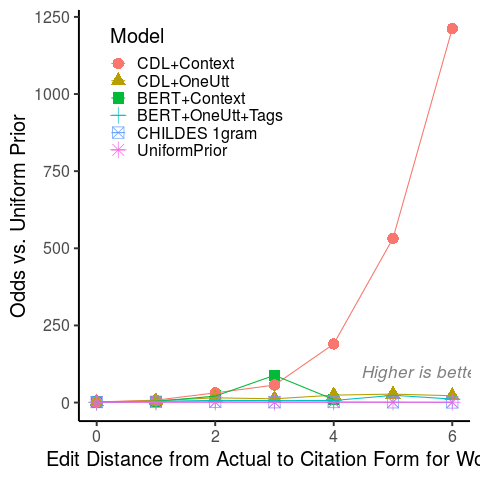

In [75]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.3, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_dstance_linear_scale.pdf', height=6, width=8)    
print(p2)

# 13 ROC for Completions 

In [76]:
%%R
library(plotROC)

In [77]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 11402  5081


In [78]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

[1] "BERT+OneUtt+Tags" "BERT+Context"     "CDL+OneUtt"       "CDL+Context"     
[5] "UniformPrior"     "CHILDES 1gram"   


In [79]:
%%R
library('pROC')
auc_by_model = do.call('rbind', lapply(unique(scores_across_time_short$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name)
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc = auc(roc1)))}))

scores_across_time_short = merge(scores_across_time_short, auc_by_model)


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following object is masked from ‘package:plotROC’:

    ggroc


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls 

In [80]:
%%R
scores_across_time_short$model_with_auc = paste0(scores_across_time_short$model,' (AUC = ',
round(scores_across_time_short$auc, 2),')')

In [81]:
%%R
scores_across_time_short$model_with_auc[1:10]

 [1] "BERT+Context (AUC = 0.86)" "BERT+Context (AUC = 0.86)"
 [3] "BERT+Context (AUC = 0.86)" "BERT+Context (AUC = 0.86)"
 [5] "BERT+Context (AUC = 0.86)" "BERT+Context (AUC = 0.86)"
 [7] "BERT+Context (AUC = 0.86)" "BERT+Context (AUC = 0.86)"
 [9] "BERT+Context (AUC = 0.86)" "BERT+Context (AUC = 0.86)"


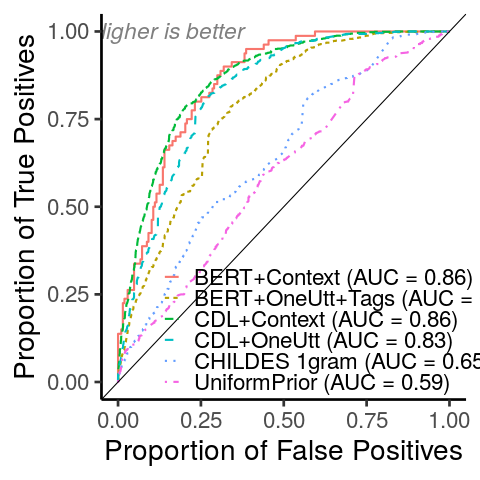

In [82]:
%%R 
p1 = ggplot(scores_across_time_short[,c('set_binarized', 'model_with_auc', 'posterior_entropy')], 
       aes(d=set_binarized, m=posterior_entropy, color=model_with_auc, linetype = model_with_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('figures/roc_2.pdf', height=8, width=8)    